# MCMC in Gen

Adapted from the official Gen tutorial: https://www.gen.dev/tutorials/iterative-inference/tutorial.


## The task: curve-fitting with outliers

Suppose we have a dataset of points in the $x,y$ plane that is _mostly_ explained by a linear relationship, but which also has several outliers. Our goal will be to automatically identify the outliers, and to find a linear relationship (a slope and intercept, as well as an inherent noise level) that explains rest of the points:

<img src="./images/example-inference.png" alt="See https://dspace.mit.edu/bitstream/handle/1721.1/119255/MIT-CSAIL-TR-2018-020.pdf, Figure 2(a))" width="600"/>

This is a simple inference problem. But it is ideal for introducing  concepts in modeling and inference. 

In particular, we want not only to estimate the slope and intercept of the line that best fits the data, but also to classify each point as an inlier or outlier; that is, there are a large number of latent variables of interest, enough to make importance sampling an unreliable method (absent a more involved custom proposal that does the heavy lifting). 

Let's get started!

(This example will be fun to turn back to when we talk optimization for inference -- several of the parameters we're estimating [the slope and intercept] are continuous and amenable to gradient-based search techniques. See the final optsection of this notebook on MAP optimization.)

## Outline

**Section 1.** [Writing the model: a first attempt](#writing-model)

**Section 2.** [Visualizing the model's behavior](#visualizing)

**Section 3.** [ The problem with generic importance sampling ](#importance)

**Section 4.** [MCMC Inference Part 1: Block Resimulation](#mcmc-1)

**Section 5.** [MCMC Inference Part 2: Gaussian Drift](#mcmc-2)

**Section 6.** [MCMC Inference Part 3: Proposals based on heuristics](#mcmc-3)

In [1]:
import Random
using Gen, Plots

## 1. Writing the model <a name="writing-model"></a>

We begin, as usual, by writing a model: a generative function. This can be conceptualized as a function responsible
for simulating a synthetic dataset.

Our model will take as input a vector of `x` coordinates, and produce as
output corresponding `y` coordinates. 

We will use this opportunity to introduce some syntactic sugar.
Random choices in Gen are given
_addresses_ using the syntax `{addr} ~ distribution(...)`. But this can
be a bit verbose, and often leads to code that looks like the following:

```julia
x = {:x} ~ normal(0, 1)
slope = {:slope} ~ normal(0, 1)
```

In these examples, the variable name is duplicated as the address of the
random choice. Because this is a common pattern, Gen provides syntactic
sugar that makes it nicer to use:

```julia
# Desugars to "x = {:x} ~ normal(0, 1)"
x ~ normal(0, 1)
# Desugars to "slope = {:slope} ~ normal(0, 1)"
slope ~ normal(0, 1)
```

Note that sometimes, it is still necessary to use the `{...}` form, for example
in loops:

```julia
# INVALID:
for i=1:10
    y ~ normal(0, 1) # The name :y will be used more than once!!
    println(y)
end

# VALID:
for i=1:10
    y = {(:y, i)} ~ normal(0, 1) # OK: the address is different each time.
    println(y)
end
```

We'll use this new syntax for writing our model of linear regression with
outliers. The model generates parameters from a prior,
and then simulates observables based on those parameters:

In [2]:
@gen function regression_with_outliers(xs::Vector{<:Real})
    # First, generate some parameters of the model. We make these
    # random choices, because later, we will want to infer them
    # from data. The distributions we use here express our assumptions
    # about the parameters: we think the slope and intercept won't be
    # too far from 0; that the noise is relatively small; and that
    # the proportion of the dataset that don't fit a linear relationship
    # (outliers) could be anything between 0 and 1.
    slope ~ normal(0, 2)
    intercept ~ normal(0, 2)
    noise ~ gamma(1, 1)
    prob_outlier ~ uniform(0, 1)
    
    # Next, we generate the observable y coordinates (outcome variable in linear regression).
    n = length(xs)
    ys = Float64[]
    
    for i = 1:n
        # Decide whether this point is an outlier, and set
        # mean and standard deviation accordingly
        if ({:data => i => :is_outlier} ~ bernoulli(prob_outlier))
            (mu, std) = (0., 10.)
        else
            (mu, std) = (xs[i] * slope + intercept, noise)
        end
        # Sample a y value for this point
        push!(ys, {:data => i => :y} ~ normal(mu, std))
    end
    ys
end;

## 2. What our model is doing: visualizing the prior 

Let's visualize what our model is doing by drawing several samples from the prior.

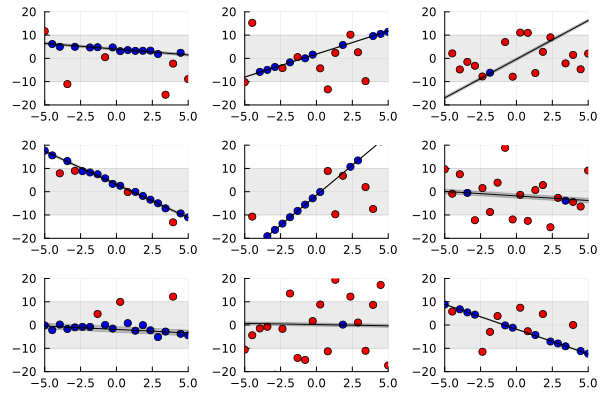

In [3]:
# Generate nine traces and visualize them
include("visualization/regression_viz.jl")
xs     = collect(range(-5, stop=5, length=20))
traces = [Gen.simulate(regression_with_outliers, (xs,)) for i in 1:9];
Plots.plot([visualize_trace(t) for t in traces]...)

##### Legend:

* red points: outliers;
* blue points: inliers (i.e. regular data);
* dark grey shading: noise associated with inliers; and
* light grey shading: noise associated with outliers.

Note that an outlier can occur anywhere — including close to the line — and
that our model is capable of generating datasets in which the vast majority
of points are outliers.

## 3. The problem with generic importance sampling  <a name="generic-importance"></a>

To motivate the need for more complex inference algorithms, let's begin by
using the simple importance sampling method from the previous tutorial, and
thinking about where it fails.

First, let us create a synthetic dataset to do inference _about_.

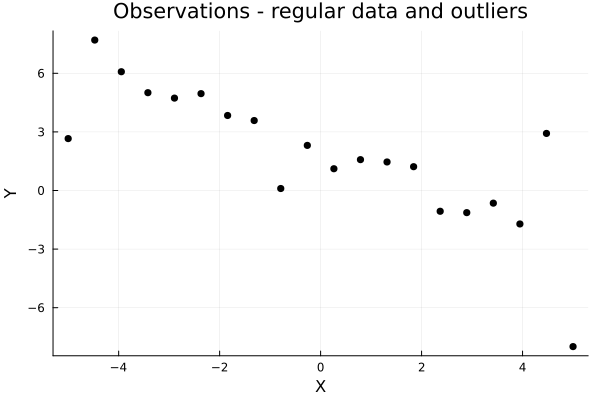

In [4]:
function make_synthetic_dataset(n)
    # setting the random seed ensures that the dataset is replicable
    Random.seed!(1)
    prob_outlier = 0.2
    true_inlier_noise = 0.5
    true_outlier_noise = 5.0
    true_slope = -1
    true_intercept = 2
    xs = collect(range(-5, stop=5, length=n))
    ys = Float64[]
    for (i, x) in enumerate(xs)
        if rand() < prob_outlier
            y = randn() * true_outlier_noise
        else
            y = true_slope * x + true_intercept + randn() * true_inlier_noise
        end
        push!(ys, y)
    end
    (xs, ys)
end
    
(xs, ys) = make_synthetic_dataset(20);
Plots.scatter(xs, ys, color="black", xlabel="X", ylabel="Y", 
              label=nothing, title="Observations - regular data and outliers")

We will need to express our _observations_ as a `ChoiceMap` that constrains the
values of certain random choices to their observed values. Here, we
want to constrain the values of the choices with address `:data => i => :y`
(that is, the sampled $y$ coordinates) to equal the observed $y$ values.
Let's write a helper function that takes in a vector of $y$ values and
creates a `ChoiceMap` that we can use to constrain our model:

In [5]:
function make_constraints(ys::Vector{Float64})
    constraints = Gen.choicemap()
    for i=1:length(ys)
        constraints[:data => i => :y] = ys[i]
    end
    constraints
end;

We can apply it to our dataset's vector of `ys` to make a set of constraints
for doing inference:

In [6]:
observations = make_constraints(ys);

Now, we use the library function `importance_resampling` to draw approximate
posterior samples given those observations:

In [7]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;

Average log probability: -51.8570956904098


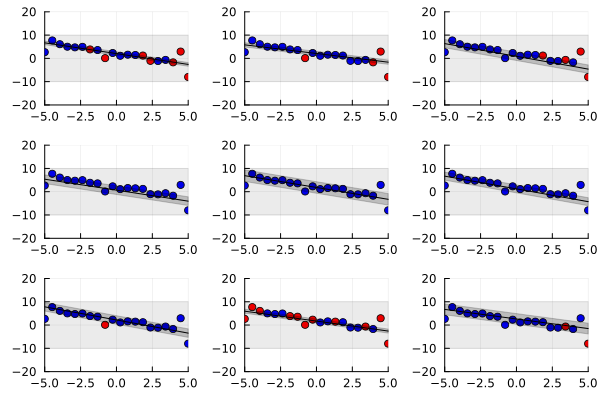

In [8]:
traces    = [first(Gen.importance_resampling(regression_with_outliers, (xs,), observations, 2000)) for i in 1:9]
log_probs = [get_score(t) for t in traces]
println("Average log probability: $(logmeanexp(log_probs))")
Plots.plot([visualize_trace(t) for t in traces]...)

We see here that importance resampling hasn't completely failed: it generally
finds a reasonable position for the line. But the details are off: there is
little logic to the outlier classification, and the inferred noise around the
line is too wide. The problem is that there are just too many variables to
get right, and so sampling everything in one go is highly unlikely to produce
a perfect hit.

In the remainder of this notebook, we'll explore techniques for finding the
right solution _iteratively_, beginning with an initial guess and making many
small changes, until we achieve a reasonable posterior sample.

## 4. MCMC Inference Part 1: Block Resimulation  <a name="mcmc-1"></a>

### What is MCMC?

_Markov Chain Monte Carlo_ ("MCMC") methods are a powerful family of
algorithms for iteratively producing approximate samples from a distribution. 
In Bayesian inference, this corresponds to drawing approximate samples from 
the posterior distribution of model variables given data.

There is a rich theory behind MCMC methods, but we focus on applying MCMC in
Gen and introducing theoretical ideas only when necessary for understanding.
As we will see, Gen provides abstractions that hide and automate much of the
math necessary for implementing MCMC algorithms correctly.

The general shape of an MCMC algorithm is as follows. We begin by sampling an
intial setting of all unobserved variables; in Gen, we produce an initial
_trace_ consistent with (but not necessarily _probable_ given) our
observations. Then, in a long-running loop, we make small, stochastic changes
to the trace; in order for the algorithm to be asymptotically correct, these
stochastic updates must satisfy certain probabilistic properties.

One common way of ensuring that the updates do satisfy those properties is to
compute a _Metropolis-Hastings acceptance ratio_. Essentially, after
proposing a change to a trace, we add an "accept or reject" step that
stochastically decides whether to commit the update or to revert it. This is
an over-simplification, but generally speaking, this step ensures we are more
likely to accept changes that make our trace fit the observed data better,
and to reject ones that make our current trace worse. The algorithm also
tries not to go down dead ends: it is more likely to take an exploratory step
into a low-probability region if it knows it can easily get back to where it
came from.

Gen's `metropolis_hastings` function _automatically_ adds this
"accept/reject" check (including the correct computation of the probability
of acceptance or rejection), so that inference programmers need only
think about what sorts of updates might be useful to propose. Starting in
this section, we'll look at several design patterns for MCMC updates, and how
to apply them in Gen.

### Block Resimulation

One of the simplest strategies we can use is called Resimulation MH, and it
works as follows.

We begin, as in most iterative inference algorithms, by sampling an initial
trace from our model, fixing the observed choices to their observed values.

```julia
# Gen's `generate` function accepts a model, a tuple of arguments to the model,
# and a `ChoiceMap` representing observations (or constraints to satisfy). It returns
# a complete trace consistent with the observations, and an importance weight.  
# In this call, we ignore the weight returned.
(tr, _) = generate(regression_with_outliers, (xs,), observations)
```

Then, in each iteration of our program, we propose changes to all our model's
variables in "blocks," by erasing a set of variables from our current trace
and _resimulating_ them from the model. After resimulating each block of
choices, we perform an accept/reject step, deciding whether the proposed
changes are worth making.

```julia
# Pseudocode
for iter=1:500
    tr = maybe_update_block_1(tr)
    tr = maybe_update_block_2(tr)
    ...
    tr = maybe_update_block_n(tr)
end
```

For the regression problem, here is one possible blocking of choices:

**Block 1: `slope`, `intercept`, and `noise`.** These parameters determine
the linear relationship; resimulating them is like picking a new line. We
know from our importance sampling experiment above that before too long,
we're bound to sample something close to the right line.

**Blocks 2 through N+1: Each `is_outlier`, in its own block.** One problem we
saw with importance sampling in this problem was that it tried to sample
_every_ outlier classification at once, when in reality the chances of a
single sample that correctly classifies all the points are very low. Here, we
can choose to resimulate each `is_outlier` choice separately, and for each
one, decide whether to use the resimulated value or not.

**Block N+2: `prob_outlier`.** Finally, we can propose a new `prob_outlier`
value; in general, we can expect to accept the proposal when it is in line 
with the current hypothesized proportion of `is_outlier` choices that are 
set to `true`.

Resimulating a block of variables is the simplest form of update that Gen's
`metropolis_hastings` operator (or `mh` for short) supports. When supplied
with a _current trace_ and a _selection_ of trace addresses to resimulate,
`mh` performs the resimulation and the appropriate accept/reject check, then
returns a possibly updated trace, along with a boolean indicating whether the 
update was accepted or not. A selection is created using the `select`
method. So a single update of the scheme we proposed above would look like
this:

In [12]:
# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the line's parameters
    line_params = select(:noise, :slope, :intercept)
    (tr, _) = mh(tr, line_params)
    
    # Blocks 2-N+1: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block N+2: Update the prob_outlier parameter
    (tr, _) = mh(tr, select(:prob_outlier))
    
    # Return the updated trace
    tr
end;

All that's left is to (a) obtain an initial trace, and then (b) run that
update in a loop for as long as we'd like:

In [14]:
function block_resimulation_inference(xs, ys, observations)
    observations = make_constraints(ys)
    (tr, _) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:500
        tr = block_resimulation_update(tr)
    end
    tr
end;

Let's test it out:

In [15]:
scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = block_resimulation_inference(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  0.848019 seconds (11.08 M allocations: 650.446 MiB, 5.43% gc time, 4.43% compilation time)
  0.820530 seconds (11.06 M allocations: 648.812 MiB, 5.96% gc time)
  0.703076 seconds (11.06 M allocations: 648.812 MiB, 5.30% gc time)
  0.737435 seconds (11.06 M allocations: 648.812 MiB, 5.07% gc time)
  0.689865 seconds (11.06 M allocations: 648.812 MiB, 5.26% gc time)
  0.695834 seconds (11.06 M allocations: 648.812 MiB, 6.09% gc time)
  0.690693 seconds (11.06 M allocations: 648.812 MiB, 5.31% gc time)
  0.669559 seconds (11.06 M allocations: 648.812 MiB, 5.07% gc time)
  0.802600 seconds (11.06 M allocations: 648.812 MiB, 5.00% gc time)
  0.920329 seconds (11.06 M allocations: 648.812 MiB, 4.95% gc time)
Log probability: -50.60017850555565


We note that this is significantly better than importance sampling, even if
we run importance sampling for about the same amount of (wall-clock) time per
sample:

In [12]:
scores = Vector{Float64}(undef, 10)
for i=1:10
    @time (tr, _) = importance_resampling(regression_with_outliers, (xs,), observations, 17000)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  0.766331 seconds (12.92 M allocations: 894.409 MiB, 7.85% gc time)
  0.849067 seconds (12.92 M allocations: 894.409 MiB, 6.97% gc time)
  0.777396 seconds (12.92 M allocations: 894.409 MiB, 8.40% gc time)
  0.803380 seconds (12.92 M allocations: 894.409 MiB, 8.25% gc time)
  0.953001 seconds (12.92 M allocations: 894.409 MiB, 7.85% gc time)
  0.999087 seconds (12.92 M allocations: 894.409 MiB, 8.60% gc time)
  1.002034 seconds (12.92 M allocations: 894.409 MiB, 8.10% gc time)
  0.900417 seconds (12.92 M allocations: 894.409 MiB, 7.86% gc time)
  0.897626 seconds (12.92 M allocations: 894.409 MiB, 7.42% gc time)
  1.011860 seconds (12.92 M allocations: 894.409 MiB, 7.58% gc time)
Log probability: -53.7625847077635


It's one thing to see a log probability increase; it's better to understand
what the inference algorithm is actually doing, and to see _why_ it's doing
better.

A great tool for debugging and improving MCMC algorithms is visualization. We
can use `Plots.@animate` to produce an
animated visualization:

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/tmp.gif")
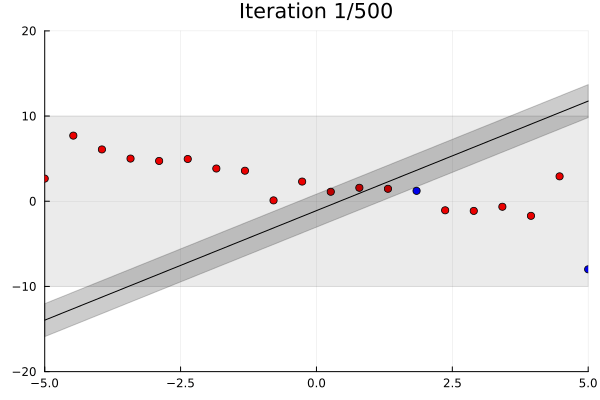

In [13]:
t, = generate(regression_with_outliers, (xs,), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = block_resimulation_update(t)
    visualize_trace(t; title="Iteration $i/500")
end;
gif(viz)

We can see that although the algorithm keeps changing the inferences of which points are inliers and outliers, 
it has a harder time refining the continuous parameters. We address this challenge next.

## 5. MCMC Inference Part 2: Gaussian Drift MH  <a name="mcmc-2"></a>

So far, we've seen one form of incremental trace update:

```julia
(tr, did_accept) = mh(tr, select(:address1, :address2, ...))
```

This update is incremental in that it only proposes changes to part of a
trace (the selected addresses). But when computing _what_ changes to propose,
it ignores the current state completely and resimulates all-new values from
the model.

That wholesale resimulation of values is often not the best way to search for
improvements. To that end, Gen also offers a more general flavor of MH:

```julia
(tr, did_accept) = mh(tr, custom_proposal, custom_proposal_args)
```

A "custom proposal" is just what it sounds like: whereas before, we were
using the _default resimulation proposal_ to come up with new values for the
selected addresses, we can now pass in a generative function that samples
proposed values however it wants.

For example, here is a custom proposal that takes in a current trace, and
proposes a new slope and intercept by randomly perturbing the existing
values:

In [9]:
@gen function line_proposal(current_trace)
    slope ~ normal(current_trace[:slope], 0.5)
    intercept ~ normal(current_trace[:intercept], 0.5)
end;

This is often called a "Gaussian drift" proposal, because it essentially amounts to proposing steps of a random walk. (What makes it different from a random walk is that we will still use an MH accept/reject step to make sure we don't wander into areas of very low probability.)

To use the proposal, we write:

```julia
(tr, did_accept) = mh(tr, line_proposal, ())
```

Two things to note:

1. We no longer need to pass a selection of addresses. Instead, Gen assumes
   that whichever addresses are sampled by the proposal (in this case,
   `:slope` and `:intercept`) are being proposed to.

2. The argument list to the proposal is an empty tuple, `()`. The
   `line_proposal` generative function does expect an argument, the previous
   trace, but this is supplied automatically to all MH custom proposals
   (a proposal generative function for use with `mh` must take as its first argument the 
   current trace of the model).

Let's swap it into our update:

In [10]:
function gaussian_drift_update(tr)
    # Gaussian drift on line params
    (tr, _) = mh(tr, line_proposal, ())
    
    # Block resimulation: Update the outlier classifications
    (xs,) = get_args(tr)
    n = length(xs)
    for i=1:n
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end
    
    # Block resimulation: Update the prob_outlier parameter
    (tr, w) = mh(tr, select(:prob_outlier))
    (tr, w) = mh(tr, select(:noise))
    tr
end;

If we compare the Gaussian Drift proposal visually with our old algorithm, we
can see the new behavior:

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/tmp.gif")
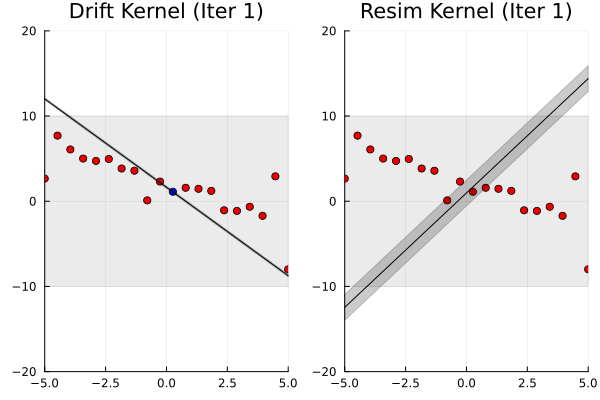

In [16]:
tr1, = generate(regression_with_outliers, (xs,), observations)
tr2 = tr1

viz = Plots.@animate for i in 1:300
    global tr1, tr2
    tr1 = gaussian_drift_update(tr1)
    tr2 = block_resimulation_update(tr2)
    Plots.plot(visualize_trace(tr1; title="Drift Kernel (Iter $i)"), 
               visualize_trace(tr2; title="Resim Kernel (Iter $i)"))
end;
gif(viz)

### Analyzing the algorithms

Compare the two
algorithms with respect to the following:

- How fast do they find a relatively good line?

- Does one of them tend to get stuck more than the other? Under what
  conditions? Why?

A more quantitative comparison demonstrates that our change has
improved our inference quality:

In [17]:
function gaussian_drift_inference(xs, observations)
    (tr, _) = generate(regression_with_outliers, (xs,), observations)
    for iter=1:500
        tr = gaussian_drift_update(tr)
    end
    tr
end

scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = gaussian_drift_inference(xs, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  1.051416 seconds (12.01 M allocations: 699.933 MiB, 5.93% gc time, 1.19% compilation time)
  1.161278 seconds (12.00 M allocations: 699.043 MiB, 5.36% gc time)
  1.032212 seconds (12.00 M allocations: 699.043 MiB, 5.30% gc time)
  0.732046 seconds (12.00 M allocations: 699.043 MiB, 6.20% gc time)
  0.967897 seconds (12.00 M allocations: 699.043 MiB, 5.54% gc time)
  0.947385 seconds (12.00 M allocations: 699.043 MiB, 5.59% gc time)
  1.106322 seconds (12.00 M allocations: 699.043 MiB, 5.77% gc time)
  1.220370 seconds (12.00 M allocations: 699.043 MiB, 4.90% gc time)
  0.815143 seconds (12.00 M allocations: 699.043 MiB, 5.54% gc time)
  0.778490 seconds (12.00 M allocations: 699.043 MiB, 6.39% gc time)
Log probability: -44.24115015595737


## 6. MCMC Inference Part 3: Heuristics to guide the process  <a name="mcmc-3"></a>

In this section, we'll look at another strategy for improving MCMC inference:
using arbitrary heuristics to make smarter proposals. In particular, we'll
use a method called "Random Sample Consensus" (or RANSAC) to quickly find
promising settings of the slope and intercept parameters.

RANSAC works as follows:
1. We repeatedly choose a small random subset of the points, say, of size 3.
2. We do least-squares linear regression to find a line of best fit for those
   points.
3. We count how many points (from the entire set) are near the line we found.
4. After a suitable number of iterations (say, 10), we return the line that
   had the highest score.

Here's our implementation of the algorithm in Julia:

In [17]:
# The StatsBase package, which we will need to implement the RANSAC algorithm
# is not part of the container so we need to install it locally as the following.
# This should run quickly.
using Pkg
Pkg.activate("myproject")
Pkg.add("StatsBase")
using StatsBase

  Activating project at `~/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/myproject`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/myproject/Project.toml`
  No Changes to `~/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/myproject/Manifest.toml`


In [18]:
import StatsBase

struct RANSACParams
    """the number of random subsets to try"""
    iters::Int

    """the number of points to use to construct a hypothesis"""
    subset_size::Int

    """the error threshold below which a datum is considered an inlier"""
    eps::Float64
    
    function RANSACParams(iters, subset_size, eps)
        if iters < 1
            error("iters < 1")
        end
        new(iters, subset_size, eps)
    end
end

In [19]:
function ransac(xs::Vector{Float64}, ys::Vector{Float64}, params::RANSACParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    for i=1:params.iters
        # select a random subset of points
        rand_ind = StatsBase.sample(1:length(xs), params.subset_size, replace=false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
        A = hcat(subset_xs, ones(length(subset_xs)))
        slope, intercept = A \ subset_ys # use backslash operator for least sq soln
        
        ypred = intercept .+ slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs.(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_num_inliers = num_inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept)
end;

We can now wrap it in a Gen proposal that calls out to RANSAC, then samples a
slope and intercept near the one it proposed.

In [20]:
@gen function ransac_proposal(prev_trace, xs, ys)
    (slope_guess, intercept_guess) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope ~ normal(slope_guess, 0.1)
    intercept ~ normal(intercept_guess, 1.0)
end;

(Notice that although `ransac` makes random choices, they are not addressed
(and they happen outside of a Gen generative function), so Gen cannot reason
about them. This is OK (see [1]). Writing proposals that have
traced internal randomness (i.e., that make traced random choices that are
not directly used in the proposal) can lead to better inference, but requires
the use of a more complex version of Gen's `mh` operator, which is beyond the
scope of this tutorial.)

[1] [Using probabilistic programs as
proposals](https://arxiv.org/abs/1801.03612), Marco F. Cusumano-Towner, Vikash K. Mansinghka, 2018.

One iteration of our update algorithm will now look like this:

In [21]:
function ransac_update(tr)
    # Use RANSAC to (potentially) jump to a better line
    # from wherever we are
    (tr, _) = mh(tr, ransac_proposal, (xs, ys))
    
    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    for j=1:20
        (tr, _) = mh(tr, select(:prob_outlier))
        (tr, _) = mh(tr, select(:noise))
        (tr, _) = mh(tr, line_proposal, ())
        # Reclassify outliers
        for i=1:length(get_args(tr)[1])
            (tr, _) = mh(tr, select(:data => i => :is_outlier))
        end
    end
    tr
end

ransac_update (generic function with 1 method)

We can now run our main loop for just 5 iterations, and achieve pretty good
results. (Of course, since we do 20 inner loop iterations in `ransac_update`,
this is really closer to 100 iterations.) The running time is significantly
less than before, without a real dip in quality:

In [22]:
function ransac_inference(xs, ys, observations)
    (slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
    slope_intercept_init = choicemap()
    slope_intercept_init[:slope] = slope
    slope_intercept_init[:intercept] = intercept
    (tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))
    for iter=1:5
        tr = ransac_update(tr)
    end
    tr
end

ransac_inference (generic function with 1 method)

In [23]:
scores = Vector{Float64}(undef, 10)
for i=1:10
    @time tr = ransac_inference(xs, ys, observations)
    scores[i] = get_score(tr)
end
println("Log probability: ", logmeanexp(scores))

  1.124716 seconds (3.70 M allocations: 231.047 MiB, 2.77% gc time, 78.28% compilation time)
  0.216290 seconds (2.41 M allocations: 144.268 MiB, 5.20% gc time)
  0.209188 seconds (2.41 M allocations: 144.268 MiB, 5.29% gc time)
  0.217295 seconds (2.41 M allocations: 144.268 MiB, 7.28% gc time)
  0.209403 seconds (2.41 M allocations: 144.268 MiB, 5.36% gc time)
  0.203742 seconds (2.41 M allocations: 144.268 MiB, 5.43% gc time)
  0.214128 seconds (2.41 M allocations: 144.268 MiB, 7.00% gc time)
  0.204401 seconds (2.41 M allocations: 144.268 MiB, 5.41% gc time)
  0.211390 seconds (2.41 M allocations: 144.268 MiB, 5.29% gc time)
  0.209436 seconds (2.41 M allocations: 144.268 MiB, 5.27% gc time)
Log probability: -46.124864791566125


Let's visualize the algorithm:

In [24]:
(slope, intercept) = ransac(xs, ys, RANSACParams(10, 3, 1.))
slope_intercept_init = choicemap()
slope_intercept_init[:slope] = slope
slope_intercept_init[:intercept] = intercept
(tr, _) = generate(regression_with_outliers, (xs,), merge(observations, slope_intercept_init))

viz = Plots.@animate for i in 1:100
    global tr

    if i % 20 == 0
        (tr, _) = mh(tr, ransac_proposal, (xs, ys))
    end

    # Spend a while refining the parameters, using Gaussian drift
    # to tune the slope and intercept, and resimulation for the noise
    # and outliers.
    (tr, _) = mh(tr, select(:prob_outlier))
    (tr, _) = mh(tr, select(:noise))
    (tr, _) = mh(tr, line_proposal, ())
    
    # Reclassify outliers
    for i=1:length(get_args(tr)[1])
        (tr, _) = mh(tr, select(:data => i => :is_outlier))
    end

    visualize_trace(tr; title="Iteration $i")
end;

[ Info: Saved animation to /Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/tmp.gif


Plots.AnimatedGif("/Users/tianminshu/Documents/Courses/CognitiveAI/Slides/Week 4/MCMC_in_Gen/tmp.gif")
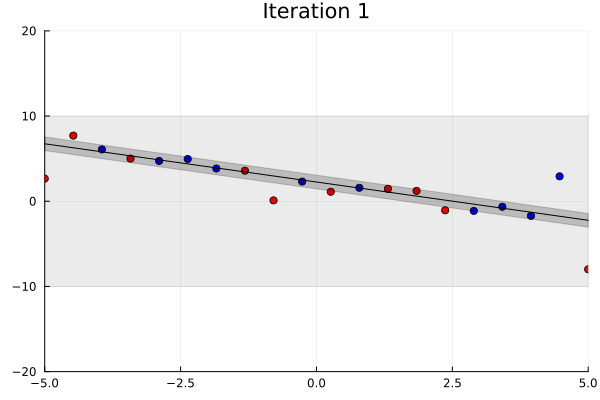

In [25]:
gif(viz)